In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import random
import time
import pickle
import gc
import re
import itertools

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
main_dir = '/tf/notebooks/'

In [4]:
ldadata_path = main_dir+'final-project/LDA/data/gender/'

In [5]:
all_speeches_topics_df = pd.read_pickle(ldadata_path+'speeches_topics_20')
all_speeches_topics_df.shape

(62716, 7)

In [6]:
all_speeches_topics_df.head()

,Topic_Count,Prim_Topic,Prim_Topic_Contrib,Prim_Topic_Keywords,Sec_Topic,Sec_Topic_Contrib,Speech_id
0,3.0,8.0,0.68,"vote,republican,house,rule,debate,majority,rep...",1.0,0.15,1080099024
1,10.0,10.0,0.61,"american,live,nation,day,world,great,history,a...",5.0,0.12,1080165561
2,7.0,7.0,0.41,"military,defense,war,veterans,iraq,service,for...",3.0,0.33,1090156218
3,7.0,4.0,0.71,"get,think,want,know,come,talk,let,way,see,country",8.0,0.13,1060121740
4,10.0,6.0,0.45,"fund,federal,service,program,provide,project,s...",9.0,0.12,1100177577


In [7]:
all_speeches_topics_df.Speech_id = all_speeches_topics_df.Speech_id.astype('int')

In [8]:
classdata_path = main_dir+'final-project/Classification/data/gender'

In [9]:
descr_pred_df = pd.read_pickle(os.path.join(classdata_path, 'gender_preds.pkl'))
descr_pred_df.shape

(62716, 20)

In [10]:
descr_pred_df.head()

,speech_id,date,char_count,word_count,speakerid,Party,Congress,Chamber,State,Ethnicity,Age,Age_lt_med,NonWhite,Female,speaker,Full Name,match,ids,pred_probs_combo,pred_combo
0,1080099024,20031030,436,70,108118820.0,D,108,H,CA,W,66.0,0.0,0.0,1.0,Mrs. CAPPS,"CAPPS, LOIS",fuzzy,1080099024,0.637449,True
1,1080165561,20040625,6213,1056,108120190.0,D,108,H,CA,B,58.0,0.0,1.0,1.0,Ms. LEE,"LEE, BARBARA",fuzzy,1080165561,0.793786,True
2,1090156218,20060711,1230,198,109116060.0,D,109,H,CA,H,49.0,1.0,1.0,1.0,Ms. SOLIS,"SOLIS, HILDA",exact,1090156218,0.861398,True
3,1060121740,20000315,700,136,106117690.0,D,106,H,NY,W,56.0,0.0,0.0,1.0,Mrs. McCARTHY of New York,"MCCARTHY, CAROLYN",exact,1060121740,0.670314,True
4,1100177577,20080623,3302,490,110114720.0,R,110,H,VA,W,59.0,0.0,0.0,1.0,Mrs. DRAKE,"DRAKE, THELMA",exact,1100177577,0.537273,True


In [11]:
final_df = descr_pred_df.merge(all_speeches_topics_df, 
                               left_on='speech_id',
                               right_on='Speech_id')
final_df.shape

(62716, 27)

In [12]:
final_df['Correct_pred'] = final_df.Female == final_df.pred_combo
np.mean(final_df['Correct_pred'])

0.8281140378850692

### Average gender score by topic

In [13]:
final_df[['pred_probs_combo', 'Correct_pred', 'Prim_Topic']]\
        .groupby('Prim_Topic')\
        .agg({'pred_probs_combo': ['count', 'mean'],
              'Correct_pred': ['mean']})\
        .sort_values(by=('pred_probs_combo','mean'), ascending=False)

Correct_pred pred_probs_combo          
                   mean            count      mean
Prim_Topic                                        
11.0           0.837948             2203  0.615217
3.0            0.835436             1823  0.609134
15.0           0.840267             1346  0.605278
13.0           0.831969             2321  0.584838
7.0            0.811741              988  0.561723
6.0            0.809985             2584  0.553268
10.0           0.814870             4035  0.550787
14.0           0.814109             5670  0.541568
5.0            0.839963             1081  0.532844
19.0           0.800110             1826  0.530349
0.0            0.804917             1261  0.528895
16.0           0.816340             1481  0.524432
2.0            0.821711             2653  0.498861
17.0           0.832071             3168  0.486024
9.0            0.824256             4939  0.478459
4.0            0.844097            11334  0.477210
8.0            0.840678             2065  0.467195
12.0           0.826964             6149  0.446194
1.0            0.827188             3553  0.438486
18.0           0.849284             2236  0.412573

In [14]:
final_df[['pred_probs_combo', 'Correct_pred', 'Sec_Topic']]\
        .groupby('Sec_Topic')\
        .agg({'pred_probs_combo': ['count', 'mean'],
              'Correct_pred': ['mean']})\
        .sort_values(by=('pred_probs_combo','mean'), ascending=False)

Correct_pred pred_probs_combo          
                  mean            count      mean
Sec_Topic                                        
 3.0          0.830211             2509  0.582238
 15.0         0.825000             1760  0.576140
 11.0         0.842826             1826  0.567786
 13.0         0.826349             2816  0.557344
 14.0         0.813622             3230  0.550247
 10.0         0.823001             4791  0.546074
 6.0          0.821429             3332  0.538249
 7.0          0.808710             1814  0.523900
 0.0          0.827260             1482  0.514237
 5.0          0.844142             1835  0.509174
 16.0         0.805340             2060  0.507654
 19.0         0.820412             2038  0.499398
 4.0          0.840558             7890  0.496441
 17.0         0.827650             3226  0.496418
 2.0          0.830031             2271  0.494685
-1.0          0.797599              583  0.487813
 9.0          0.826471             4639  0.474292
 12.0         0.825413             6839  0.472118
 1.0          0.819174             3025  0.448595
 8.0          0.854230             2305  0.436850
 18.0         0.849080             2445  0.421242

### Topics by Congress

In [15]:
congress_df = final_df[['Congress', 'Prim_Topic', 'speech_id', 'Female', 'pred_probs_combo']]\
                .groupby(['Congress', 'Prim_Topic'])\
                .agg({'speech_id': ['count'], 'Female': ['mean', 'sum'], 'pred_probs_combo': ['mean']})\
                .reset_index()
congress_df.columns = ['_'.join(col) for col in congress_df.columns]
congress_df.shape

(360, 6)

In [16]:
congress_df.head()

,Congress_,Prim_Topic_,pred_probs_combo_mean,Female_mean,Female_sum,speech_id_count
0,97,0.0,0.415010,0.240741,13.0,54
1,97,1.0,0.334204,0.112108,25.0,223
2,97,2.0,0.397596,0.234483,34.0,145
3,97,3.0,0.487076,0.381818,21.0,55
4,97,4.0,0.347634,0.185990,77.0,414


In [17]:
top_gender_topics = [11,3,15,13]
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple']

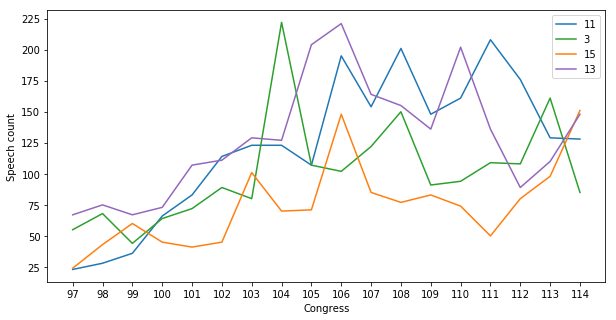

In [18]:
plt.figure(figsize=(10,5))
plt.xlabel('Congress')
plt.ylabel('Speech count')

for i in range(len(top_gender_topics)):
    x = congress_df[congress_df.Prim_Topic_==top_gender_topics[i]].Congress_
    y = congress_df[congress_df.Prim_Topic_==top_gender_topics[i]].speech_id_count
    plt.plot(x, y, color=colors[i], label=top_gender_topics[i])
    plt.xticks(range(97,115))
    plt.legend()

### Top topics in probability bins

In [19]:
bins = np.linspace(0,1,6)
final_df['binned'] = np.digitize(final_df.pred_probs_combo, bins)
final_df['binned'].value_counts()

3    19387
4    17073
2    16810
5     5156
1     4290
Name: binned, dtype: int64

In [59]:
topic_share = final_df[['Prim_Topic', 'speech_id']].groupby('Prim_Topic').count() / final_df.shape[0]
topic_share.columns = ['topic_share']
topic_share.reset_index(inplace=True)
topic_share.head()

,Prim_Topic,topic_share
0,0.0,0.020107
1,1.0,0.056652
2,2.0,0.042302
3,3.0,0.029068
4,4.0,0.180719


In [68]:
prob_by_bin = final_df[['binned', 'pred_probs_combo']].groupby('binned').max() 
prob_by_bin.reset_index(inplace=True)
prob_by_bin.columns = ['Bin', 'bin_max_prob']
prob_by_bin.head()

,Bin,bin_max_prob
0,1,0.199982
1,2,0.399994
2,3,0.599996
3,4,0.799998
4,5,0.996077


In [42]:
cnt_by_bin = final_df[['binned', 'speech_id']].groupby(['binned']).count().reset_index()
cnt_by_bin.columns = ['Bin', 'Speech_cnt_bin']
cnt_by_bin.head()

,Bin,Speech_cnt_bin
0,1,4290
1,2,16810
2,3,19387
3,4,17073
4,5,5156


In [69]:
cnt_by_bin_topic = final_df[['Prim_Topic', 'binned', 'speech_id']].groupby(['binned', 'Prim_Topic']).count().reset_index()
cnt_by_bin_topic.columns = ['Bin', 'Prim_Topic', 'Speech_cnt_bin_topic']
cnt_by_bin_topic = cnt_by_bin_topic.merge(cnt_by_bin, on='Bin')
cnt_by_bin_topic['topic_bin_share'] = cnt_by_bin_topic.Speech_cnt_bin_topic / cnt_by_bin_topic.Speech_cnt_bin
cnt_by_bin_topic = cnt_by_bin_topic.merge(topic_share, on='Prim_Topic').merge(prob_by_bin, on='Bin')
cnt_by_bin_topic['topic_share_index'] = cnt_by_bin_topic.topic_bin_share / cnt_by_bin_topic.topic_share
cnt_by_bin_topic.head()

,Bin,Prim_Topic,Speech_cnt_bin_topic,Speech_cnt_bin,topic_bin_share,topic_share,bin_max_prob,topic_share_index
0,1,0.0,40,4290,0.009324,0.020107,0.199982,0.463731
1,1,1.0,354,4290,0.082517,0.056652,0.199982,1.456562
2,1,2.0,146,4290,0.034033,0.042302,0.199982,0.804520
3,1,3.0,33,4290,0.007692,0.029068,0.199982,0.264636
4,1,4.0,1130,4290,0.263403,0.180719,0.199982,1.457526


In [77]:
for b in range(1,len(bins)+1):
    temp = cnt_by_bin_topic[cnt_by_bin_topic['Bin']==b]
    temp = temp.sort_values(by='topic_share_index', ascending=False)
    temp = temp[['bin_max_prob', 'Prim_Topic', 'topic_share_index']]
    print(temp.head())

    bin_max_prob  Prim_Topic  topic_share_index
18      0.199982        18.0           2.007186
8       0.199982         8.0           1.713233
4       0.199982         4.0           1.457526
1       0.199982         1.0           1.456562
12      0.199982        12.0           1.440752
    bin_max_prob  Prim_Topic  topic_share_index
38      0.399994        18.0           1.431615
21      0.399994         1.0           1.338831
32      0.399994        12.0           1.296614
29      0.399994         9.0           1.150460
37      0.399994        17.0           1.122324
    bin_max_prob  Prim_Topic  topic_share_index
40      0.599996         0.0           1.097985
47      0.599996         7.0           1.067403
54      0.599996        14.0           1.066336
50      0.599996        10.0           1.058274
59      0.599996        19.0           1.052334
    bin_max_prob  Prim_Topic  topic_share_index
63      0.799998         3.0           1.434702
71      0.799998        11.0           1

In [135]:
NUM_COLORS = 20
cm = plt.get_cmap('gist_rainbow')

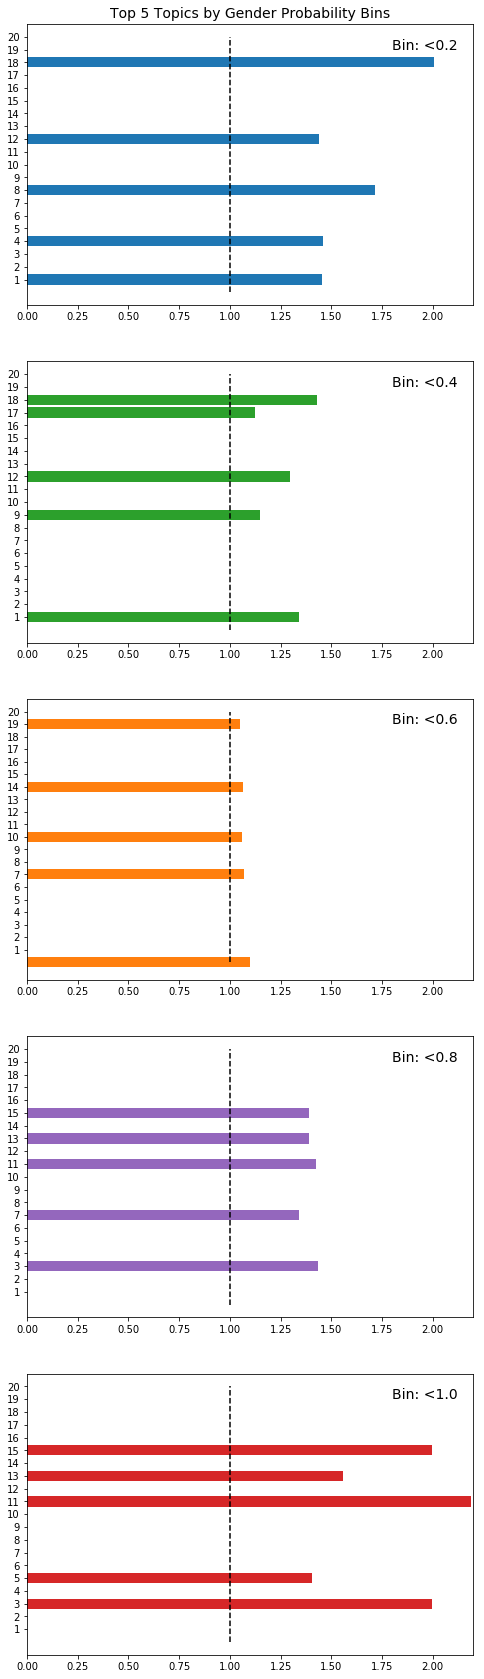

In [142]:
fig, axes = plt.subplots(nrows=len(bins)-1, figsize=(8, 30))
# fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
# fig.suptitle('Topic Share Index', fontsize=14)
axes[0].set_title('Top 5 Topics by Gender Probability Bins', fontsize=14)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']

for ax, b in zip(axes, range(len(bins)-1)):
    temp = cnt_by_bin_topic[cnt_by_bin_topic['Bin']==b+1]
    temp = temp.sort_values(by='topic_share_index', ascending=False)
    temp = temp[['bin_max_prob', 'Prim_Topic', 'topic_share_index']]
    temp = temp.head()
    ax.text(1.8, 19, "Bin: <"+str(round(max(temp.bin_max_prob),2)), fontsize=14)
    ax.barh(temp.Prim_Topic, temp.topic_share_index, align='center', color=colors[b])
    ax.vlines(x=1,ymin=0,ymax=20, linestyles='dashed')
    ax.set_xlim(0,2.2)
    ax.set_yticks(range(1,21))

In [78]:
for b in range(1,len(bins)+1):
    temp = final_df[final_df['binned']==b]
    temp = temp[['speech_id', 'pred_probs_combo', 'Prim_Topic']]\
                .groupby('Prim_Topic')\
                .agg({'speech_id':['count'], 'pred_probs_combo': ['mean']})\
                .sort_values(by=('speech_id', 'count'), ascending=False)\
                .reset_index()
    print("Bin: ", bins[b-1])
    print(temp.head(5))

Bin:  0.0
  Prim_Topic pred_probs_combo speech_id
                         mean     count
0        4.0         0.150549      1130
1       12.0         0.152774       606
2        9.0         0.151636       384
3        1.0         0.152194       354
4       18.0         0.150630       307
Bin:  0.2
  Prim_Topic pred_probs_combo speech_id
                         mean     count
0        4.0         0.301095      3380
1       12.0         0.301705      2137
2        9.0         0.307053      1523
3       14.0         0.314216      1301
4        1.0         0.301800      1275
Bin:  0.4
  Prim_Topic pred_probs_combo speech_id
                         mean     count
0        4.0         0.497963      3297
1       12.0         0.495106      1927
2       14.0         0.503475      1869
3        9.0         0.496020      1536
4       10.0         0.500886      1320
Bin:  0.6000000000000001
  Prim_Topic pred_probs_combo speech_id
                         mean     count
0        4.0         0.69